# Example 3: Generate and save samples

In [51]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

6


In [52]:
# Import module. 
using Revise
using PriorNormalization

In [53]:
# Import packages 
using AdaptiveMCMC # for using adaptive MCMC sampling
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant  
using CairoMakie # for plots 
using Dates # to measure computational time 
using Distributions
using JLD2 # for saving and loading results
using FlexiMaps # for log-range  
using ForwardDiff # for AD
using LinearAlgebra # to represent the identity matrix as "I" 
using Random # for generating random noise 
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Turing # for setting up the model and sampling 
using Trixi # for setting up the semi-discretization 
using Optim # for ML and MAP estimation 
using OrdinaryDiffEq # for time integration
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Sampling parameters

We use an adaptive RWMH samples. 
See https://mvihola.github.io/docs/AdaptiveMCMC.jl/ or https://github.com/mvihola/AdaptiveMCMC.jl for details. 
We can us the following different algorithm options (see https://mvihola.github.io/docs/AdaptiveMCMC.jl/adapt/#Adaptation-state):

    :am = AdaptiveMetropolis
    :ram = RobustAdaptiveMetropolis
    :asm = AdaptiveScalingMetropolis
    :aswam = AdaptiveScalingWithinAdaptiveMetropolis

In [54]:
# Prepare arguments.  
nr_chains = 1 # number of chains to sample 
nr_samples_raw = 10^6 # number of samples 
thin = 10^2 # Thinning factor; only every thin-th sample is stored
progress = false # show progress?
MCMC_init = "prior" # Initialization option: "MAP", "prior"

# Tests: 
# nr_samples_raw = 10^5, thin = 10^1: 50s & 1m 32s
# nr_samples_raw = 10^6, thin = 10^2: 11m & 24m
# nr_samples_raw = 10^7, thin = 10^3: 81m & 258

burn_in_raw = 0 #Int64(ceil(nr_samples_raw/10)) # Burn-in length of 10% 
nr_samples = Int64( nr_samples_raw/thin )
burn_in = 0 #Int64(ceil(nr_samples/10)) # Burn-in length of 10%

0

## Burgers' problem: Define the data model 

In [55]:
# Problem parameters 
σ² = 1.0*1e-2 # noise variance  
N = 100 # number of points 
M = Int64(ceil(N/5)) # number of observational data 
Random.seed!(123) # Setting the random seed  

TaskLocalRNG()

In [56]:
## Initial data and solution 

# Piecewise constant initial data 
function initial_condition_shock(x, t, equation::InviscidBurgersEquation1D)
    RealT = eltype(x)
    scalar = abs( x[1] - 0.5 ) < 0.25 ? convert(RealT, 1.0f0) : convert(RealT, 0.0f0)

    return SVector(scalar)
end

# Reference solution at time T=0.25 
function ref_solution(x)
    
    N = length(x)
    sol_ref = zeros(N,1) 
    
    for n in 1:N 
        if x[n] >= 0.25 && x[n] < 0.5 
            sol_ref[n] = 4*(x[n] - 0.25) 
        elseif x[n] >= 0.5 && x[n] < 0.875 
            sol_ref[n] = 1
        end
    end

    return sol_ref
end

ref_solution (generic function with 1 method)

In [57]:
## Semidiscretization of the (inviscid) Burgers' equation

equations = InviscidBurgersEquation1D() 

initial_condition = initial_condition_shock

D_upw = upwind_operators(SummationByPartsOperators.Mattsson2017,
                         derivative_order = 1,
                         accuracy_order = 4,
                         xmin = -1.0, xmax = 1.0,
                         N = N)
flux_splitting = splitting_lax_friedrichs
solver = FDSBP(D_upw,
               surface_integral = SurfaceIntegralUpwind(flux_splitting),
               volume_integral = VolumeIntegralUpwind(flux_splitting))

coordinates_min = 0.0
coordinates_max = 1.0
mesh = TreeMesh(coordinates_min, coordinates_max,
                initial_refinement_level = 0,
                n_cells_max = 10_000)

semi = SemidiscretizationHyperbolic(mesh, equations, initial_condition, solver)

┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ SemidiscretizationHyperbolic                                                                     │
│ ════════════════════════════                                                                     │
│ #spatial dimensions: ………………………… 1                                                                │
│ mesh: ………………………………………………………………… TreeMesh{1, Trixi.SerialTree{1}} with length 1                   │
│ equations: …………………………………………………… InviscidBurgersEquation1D                                        │
│ initial condition: ……………………………… initial_condition_shock                                          │
│ boundary conditions: ………………………… Trixi.BoundaryConditionPeriodic                                  │
│ source terms: …………………………………………… nothing                                                          │
│ solver: …………………………………………………………… DG                                                       

In [58]:
## Get the nodal values of the true initial condition and the associated solution 

# Run the simulation 
T = 0.25
tspan = (0.0, T)
ode = semidiscretize(semi, tspan)
sol = solve(ode, SSPRK43())
 
# Grid points 
grid_u = LinRange(coordinates_min, coordinates_max, N)
grid_b = LinRange(coordinates_min, coordinates_max, M)

# Extract the initial data  
u0 = sol(0.0) 
# Extract the numerical solution   
uT_num = sol(T)
# Exact solution 
uT_ref = ref_solution(grid_u)

# Generate the observational data 
#obsData_full = uT_num .+ sqrt(σ²)*randn(length(uT_num)) 
obsData_full = uT_ref .+ sqrt(σ²)*randn(length(uT_ref)) 
obsData = obsData_full[1:Int64(ceil(N/M)):end]

20-element Vector{Float64}:
  0.08082879284649669
  0.022981869805186763
  0.12192815097319654
 -0.08900766562698115
  0.20081126248520312
  0.05704871052513616
  0.4023844850955033
  0.28523930705601064
  0.6615987487062823
  0.7074733730284238
  0.8617107722308261
  1.0758746890863273
  0.7474389459416231
  0.8534389143119507
  1.0183639757280603
  1.114809342282114
  1.0566026075396748
  0.957509472426523
 -0.003170723035024594
 -0.06787747615011162

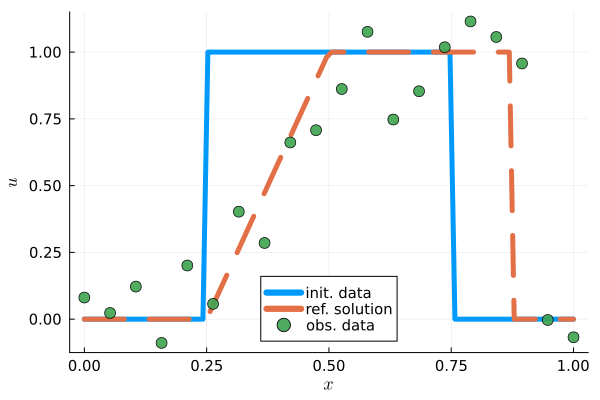

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_dataRef.pdf"

In [59]:
## Plot the init. data, ref. solution, and obs. data 
pd = plot(grid_u, u0, label="init. data", lw=5, ls=:solid)
pd = plot!(grid_u, uT_ref, label="ref. solution", lw=5, ls=:dash)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=6, alpha=0.9)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=10, labelfontsize=12, legendfontsize=10 
)

display(pd);

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_dataRef.pdf"
)
#savefig(output_filename)

### Forward operator

In [60]:
function forward_operator( v0 )
    
    # Set the initial data equal to u0
    sol_integrator = init(ode, SSPRK43())
    reinit!(sol_integrator, v0)

    # Solve Burgers' equation with the changed initial data 
    sol_aux = solve!(sol_integrator);
    vT_full =  sol_aux(0.25)
    vT = vT_full[1:Int64(ceil(N/M)):end]
    
    return vT
    
end

forward_operator (generic function with 1 method)

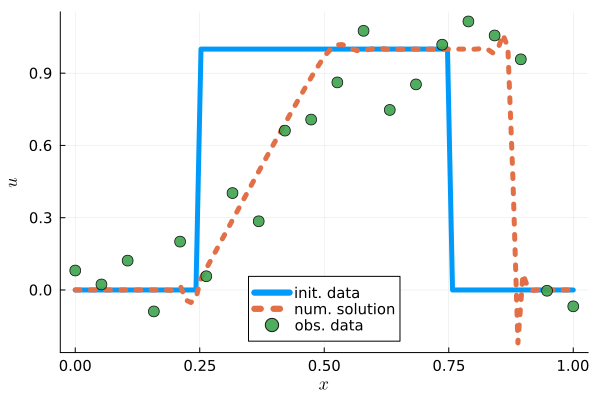

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/Burgers_dataNum.pdf"

In [61]:
## Plot the initial data 
pd = plot(grid_u, u0, label="init. data", lw=5, ls=:solid)
pd = plot!(grid_u, uT_num, label="num. solution", lw=5, ls=:dot)
pd = scatter!(grid_b, obsData, label="obs. data", markersize=6, alpha=0.9)
pd = plot!(pd,  
    #clim=(minimum(u0_fine), maximum(u0_fine)), 
    legend=:bottom, 
    xguide=L"x", yguide=L"u", title="", 
    tickfontsize=10, labelfontsize=12, legendfontsize=10 
)

display(pd)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "Burgers_dataNum.pdf"
)
#savefig(output_filename)

### The sparsifying transform

In [62]:
# Invertible finite difference matrix
aux = ones(N) * [-1.0, 1.0]'
L = spzeros(Float64, N, N)
L[2:end,:] = spdiagm(0=>-1*ones(N), 1=>ones(N))[1:N-1,1:N]
L[1,1] = 1 

display(L)

# Change coordinates to promote sparsity in v = L*u 
forwardOp( v ) = (1/sqrt(σ²)) * forward_operator( L\v ) 

# Whitening of observational data 
b = (1/sqrt(σ²)) * obsData

100×100 SparseMatrixCSC{Float64, Int64} with 199 stored entries:
⎡⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⎦

20-element Vector{Float64}:
  0.8082879284649669
  0.22981869805186764
  1.2192815097319654
 -0.8900766562698115
  2.008112624852031
  0.5704871052513616
  4.023844850955033
  2.8523930705601064
  6.6159874870628235
  7.074733730284239
  8.617107722308262
 10.758746890863273
  7.474389459416231
  8.534389143119508
 10.183639757280602
 11.14809342282114
 10.56602607539675
  9.57509472426523
 -0.03170723035024594
 -0.6787747615011163

## Generic models for the original and prior-normalized problem

In [63]:
# Different parameters of  generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

In [64]:
# Define the log-posterior density 
function logpdf_original(θ, v; forwardOp, b, r, β, ϑ)    
    if any(θ .<= 0) # any non-positive element? 
        logpdf = -Inf 
    else
        logpdf = -0.5*norm( forwardOp(v) - b )^2 - 
            0.5*sum( v.^2 ./ θ ) - 
            sum( (θ/ϑ).^r ) + 
            (r*β-1.5)*sum( log.(θ) )
    end
    
    return logpdf
end

logpdf_original (generic function with 2 methods)

In [65]:
# Define the posterior density 
function logpdf_priorNormalized(τ, w; forwardOp, b, r, β, ϑ, Φ::Function) 
    
    # Get value of log-prior
    log_prior = -0.5*sum( w.^2 + τ.^2 )
    
    # Get z-value by using transport MAP 
    N = length(w)
    v = zeros(N)
    for n in 1:N
        v[n] = priorNormalizing_KR_inv_tu( w[n], τ[n]; r, β, ϑ, Φ )
    end
    
    # Get the log of the transformed likelihood 
    log_likelihood = -0.5*norm( forwardOp(v) - b )^2

    # Get log-posterior 
    logpdf = log_prior + log_likelihood
    
    return logpdf
end

logpdf_priorNormalized (generic function with 2 methods)

## Select a model: $r=-1$

In [66]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

0.00012308

In [67]:
# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = Interval(-5, 5)
# Create an array of functions
if r > 0 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdf_cheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Calculate the value and derivative at the boundaries
Γinvccdf_val_left = Γinvccdf_cheb(interval.left)
Γinvccdf_val_right = Γinvccdf_cheb(interval.right)

Γinvccdf_deriv_left = ForwardDiff.derivative(Γinvccdf_cheb, interval.left)
Γinvccdf_deriv_right = ForwardDiff.derivative(Γinvccdf_cheb, interval.right)

# Define the extended function
function Γinvccdf_cheb_extd(τ)
    if τ < interval.left
        return Γinvccdf_val_left + Γinvccdf_deriv_left * (τ - interval.left)
    elseif τ > interval.right
        return abs(Γinvccdf_val_right + Γinvccdf_deriv_right * (τ - interval.right))
    else
        return Γinvccdf_cheb(τ)
    end
end

Γinvccdf_cheb_extd (generic function with 1 method)

In [68]:
# Change definition and define log-PDF
logpdf_original(ξ) = logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    forwardOp, b, r, β, ϑ
)

# Change definition and define log-PDF
logpdf_priorNormalized(ξ) = logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    forwardOp, b, r, β, ϑ, Φ=Γinvccdf_cheb_extd
)

logpdf_priorNormalized (generic function with 2 methods)

In [69]:
# Load the MAP estimates 

# MAP estimate of the original posterior 
@load "data/Burgers_model$(model_nr)_MAP_original.jld2" θ_MAP v_MAP
# Initialize an empty vector to store the interleaved values
original_MAP = Vector{Float64}(undef, 2*N)
# Interleave τ_MAP and u_MAP
original_MAP[1:2:end] .= θ_MAP
original_MAP[2:2:end] .= v_MAP

# MAP estimate of the prior-normalized posterior 
@load "data/Burgers_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP w_MAP
# Initialize an empty vector to store the interleaved values
priorNormalized_MAP = Vector{Float64}(undef, 2*N)
# Interleave τ_MAP and u_MAP
priorNormalized_MAP[1:2:end] .= τ_MAP;
priorNormalized_MAP[2:2:end] .= w_MAP;

In [70]:
## Genrate random samples from the original prior 

original_prior = Array{Float64}(undef, 2*N, nr_chains)
# Generate θ-samples from the gamma distribution
θ_prior_samples = rand(Gamma(β,1), N, nr_chains)
# Transform them into samples of the generalized gamma distribution 
θ_prior_samples = ϑ * θ_prior_samples.^(1/r)

# Generate z-samples from the conditional Gaussian prior 
v_prior_samples = Array{Float64}(undef, N, nr_chains)
# Loop over each chain and each sample to generate the normal samples
for j in 1:nr_chains
    for n in 1:N
        # Standard deviation is sqrt(θ_prior_samples[i, j])
        σ = sqrt(θ_prior_samples[n, j])
        v_prior_samples[n, j] = rand(Normal(0, σ))
    end
    original_prior[1:2:end,j] .= θ_prior_samples[:,j]
    original_prior[2:2:end,j] .= v_prior_samples[:,j]
end
#display(init_param_original)
    
## Genrate random samples from the standard normal prior 
priorNormalized_prior = Array{Float64}(undef, 2*N, nr_chains)
τ_prior_samples = rand(Normal(0,1), N, nr_chains)
w_prior_samples = rand(Normal(0,1), N, nr_chains)

for j in 1:nr_chains
    priorNormalized_prior[1:2:end,j] .= τ_prior_samples[:,j]
    priorNormalized_prior[2:2:end,j] .= w_prior_samples[:,j]
end
#display(init_param_priorNormalized)

In [71]:
# Choose an initialization for the MCMC chains 
init_param_original = Array{Float64}(undef, 2*N, nr_chains)
init_param_priorNormalized = Array{Float64}(undef, 2*N, nr_chains)

# Use MAP estimate 
if MCMC_init=="MAP"
    # Select the initial set of parameters 
    for j in 1:nr_chains 
        init_param_original[:,j] = original_MAP[:]
        init_param_priorNormalized[:,j] = priorNormalized_MAP[:]
    end

    # Select the file names for saving the later MCMC results 
    # Original model 
    filename_original = joinpath("data", 
        "Burgers_model$(model_nr)_mcmc_initMAP_AM_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
    # Prior-normalized model 
    filename_priorNormalized = joinpath("data", 
        "Burgers_model$(model_nr)_mcmc_initMAP_AM_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

# Use random prior samples 
elseif MCMC_init=="prior"
    # Select the initial set of parameters 
    for j in 1:nr_chains 
        init_param_original[:,j] = original_prior[:,j]
        init_param_priorNormalized[:,j] = priorNormalized_prior[:,j]
    end

    # Select the file names for saving the later MCMC results 
    # Original model 
    filename_original = joinpath(
        "data", 
        "Burgers_model$(model_nr)_mcmc_initPrior_AM_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
    # Prior-normalized model 
    filename_priorNormalized = joinpath(
        "data", 
        "Burgers_model$(model_nr)_mcmc_initPrior_AM_priorNormalized_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

# Throw an error if none of the available options is provided
else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'prior'.")
end

"data/Burgers_model4_mcmc_initPrior_AM_priorNormalized_samples1000000_thin100_chains1.jld2"

## Sampling from the original posterior 

In [72]:
# Produce samples from the target distribution.
# Note: Only :asm = AdaptiveScalingMetropolis consistently works

# Initialize
nr_parameters = 2*N
chn_values = zeros(Float64, nr_samples-burn_in, nr_parameters, nr_chains)

# Start the wall clock timer
wall_start = now()

# Use multiple threads. 
@showprogress Threads.@threads for j in 1:nr_chains   
    # generate samples
    chn_values[:,:,j] = adaptive_rwm(
        init_param_original[:,j], 
        logpdf_original, 
        nr_samples_raw; # number of samples (add burn-in length) 
        algorithm=:asm, 
        b=burn_in_raw+1, # burn in length 
        thin=thin, # Thinning factor
        progress=progress # show progress meter
    ).X'
    
    # Clear memory after each chain
    GC.gc()
end

# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
# Convert wall duration to seconds
wall_duration_original = Dates.value(wall_duration_ms) / 1000

# Define the parameter names (θ[1], z[1], θ[2], z[2], ...)
param_names_θ = [string("θ[", i, "]") for i in 1:(nr_parameters÷2) ]
param_names_v = [string("v[", i, "]") for i in 1:(nr_parameters÷2) ]

# Interleave θ and z names
param_names = Vector{String}(undef, nr_parameters)
param_names[1:2:end] .= param_names_θ
param_names[2:2:end] .= param_names_v

# Create the Chains object
chn_original = Chains(chn_values, Symbol.(param_names));

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

In [73]:
# Save the MCMC chain and computational time
@save filename_original chn_original wall_duration_original

## Sampling from the prior-normalized posterior 

In [74]:
# Produce samples from the target distribution.
# Note: Only :asm = AdaptiveScalingMetropolis consistently works 

# Initialize
nr_parameters = 2*N
chn_values = zeros(Float64, nr_samples-burn_in, nr_parameters, nr_chains)

# Start the wall clock timer
wall_start = now()

# Use multiple threads. 
@showprogress Threads.@threads for j in 1:nr_chains 
    
    # generate samples
    chn_values[:,:,j] = adaptive_rwm(
        init_param_priorNormalized[:,j], 
        logpdf_priorNormalized, 
        nr_samples_raw; # number of samples (add burn-in length) 
        algorithm=:asm, 
        b=burn_in_raw+1, # burn in length 
        thin=thin, # Thinning factor
        progress=progress # show progress meter?
    ).X'
    
    # Clear memory after each chain
    GC.gc()
end
    
# End the wall clock timer
wall_end = now()
wall_duration_ms = wall_end - wall_start
# Convert wall duration to seconds
wall_duration_priorNormalized = Dates.value(wall_duration_ms) / 1000

# Define the parameter names (θ[1], z[1], θ[2], z[2], ...)
param_names_τ = [string("τ[", i, "]") for i in 1:(nr_parameters÷2) ]
param_names_w = [string("w[", i, "]") for i in 1:(nr_parameters÷2) ]

# Interleave τ and u names
param_names = Vector{String}(undef, nr_parameters)
param_names[1:2:end] .= param_names_τ
param_names[2:2:end] .= param_names_w

# Create the Chains object
chn_priorNormalized = Chains(chn_values, Symbol.(param_names));

# Free the memory occupied by chn_values
chn_values = nothing
GC.gc()  # Optionally trigger garbage collection manually

In [75]:
# Save the MCMC chain and computational time
@save filename_priorNormalized chn_priorNormalized wall_duration_priorNormalized